In [1]:
import numpy as np
import random as rd
import scipy as sc
import scipy.sparse as sp
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib notebook
import mpl_toolkits.mplot3d
import scipy.sparse.linalg
import math
import time
import cmath
import operator as o

import Maillage as m
from codetri import *
from golub import *
from bibmaillage import *
from bibmatrice import *
from Dirichlet import *
from solex import *

donnee=1
mg=m.maillage() ############### création des données du maillage (longueur du carré)
mg.triangle() ################## fonction qui fait un code a passer dans TRIANGLE, mais pas le bon finalement (maillage pas assez régulier)


In [4]:
file = open("solexacte.txt", 'r') ################### récupération de la sol exacte
line=file.readline()
a=line.split()
nbGCex=int(a[0]) 
xex=np.zeros(nbGCex)
yex=np.zeros(nbGCex)
Uexacte=np.zeros(nbGCex,dtype=complex) 
for i in range(nbGCex):
    line=file.readline()
    a=line.split()
    xex[i]=float(a[0])
    yex[i]=float(a[1])
    Uexacte[i]=complex(a[2])
file.close()

FileNotFoundError: [Errno 2] No such file or directory: 'solexacte.txt'

In [8]:
def resolution(mg,kappa,I,J,donnee):
    ################################# CRÉATION DU MAILLAGE ###################################
    x1,x2,x3,x4,h=mg.creation(I,J,donnee) ################## création du code (a donner a TRIANGLE si on veut le voir) pour avoir un maillage hyper régulier
    stilde=source(mg)
    decal=np.zeros(2)
    decal[0]=0.1
    decal[1]=0.3
    stilded=stilde+decal
    n1,pts=crea_pts() 
    n2,ele=crea_ele()
    K,ddloc,nbGD,f,f2,lambda1=fonc_donnee(n1,n2) 
    kappa=mg.k0/mg.alpha
    loc2loc,loc1toloc2=crea_loc2loc(K) 
    I=K+1
    X,rho=Gauss(I) 
    T=crea_aire(n2,pts,ele)
    Airepara=aire_para(x1,x2,x3)
    #################################### CRÉATION DES DDL CONT ET NON ###########################
    XC=Xchapeau(K,loc2loc)
    temps=time.time()
    ptsGD=crea_ptsGD(K,n2,pts,ele,XC,nbGD)
    tempstemps=time.time()
    print('creation pts',tempstemps-temps)
    ptsGDtrié=1*ptsGD
    t00=time.time()
    #trirapide(ptsGDtrié,0,len(ptsGD)-1) #on tri qd on a tt les pts ddl glob donc c'est mtn les ddlglob de GD #codetri
    ptsGDtrié=np.reshape(sorted(ptsGD,key=o.itemgetter(0,1)),np.shape(ptsGD))
    tm=time.time()
    print('temps tri',nbGD,tm-t00)
    ptsGCtrié,tri=effa(ptsGDtrié)
    t0=time.time()
    print('temps eff',nbGD,t0-tm)
    glob2loc=crea_glob2loc(n2,K,nbGD)   
    nbGC=tri[nbGD-1]+1 
    print('nbGC',nbGC)
    loc2glob=crea_loc2glob(nbGD,ptsGDtrié,tri,glob2loc,n2)
    ######################################### FACES DE BORD ####################################
    bas=0 
    gauche=1
    haut=2
    droit=3
    nbface=n2*3
    face=crea_face(n2,pts,ele,nbface)
    face=quelbord(face,nbface,mg)
    nbfacebord=calcul_nbfacebord(face,nbface)
    ddlfacebord=nbfacebord*(K+1) 
    facebord=crea_facebord(nbface,face,nbfacebord) 
    ptsGDfaceDisc=crea_ptsGDfaceDisc(K,nbfacebord,facebord,ddlfacebord,loc2glob)
    loc2globface=crea_loc2globface(K,nbfacebord,ptsGDfaceDisc)
    nbas,ngauche=normale(mg)
    ################################# MATRICES DE RÉFÉRENCE ####################################
    Mc=masse_chapeau(K,loc2loc,rho,X)
    Kcxx,Kcxy,Kcyx,Kcyy=rig_locales(K,loc2loc,rho,X)
    I2=2*(K+1)
    XI2,rhoI2=Gauss(I2)
    ###################################### SECOND MEMBRE #####################################
    F=nodal(nbGC,ptsGCtrié,f,stilde)
    ############################# CONSTRUCTION DES MATRICES ##################################
    t3=time.time()
    R=rig_globale(n2,K,pts,ele,T,Kcxx,Kcxy,Kcyx,Kcyy,loc2loc,loc2glob,nbGC)
    t4=time.time()
    print('rigidite',t4-t3)
    Masse=masse(n2,K,Mc,loc2loc,loc2glob,nbGC,T)
    t5=time.time()
    print('masse',t5-t4)
    Mbord=massebord(facebord,Z1,nbfacebord,rhoI2,XI2,ptsGDfaceDisc,stilde,loc2globface,nbGC,nbas,ngauche,kappa)
    t6=time.time()
    print('masse bord',t6-t5)
    ####################### RÉSOLUTION DU PROBLÈME ET TRACÉ DE LA SOLUTION ######################
    temps1=time.time()
    e=(R-kappa**2*Masse-1j*kappa*Mbord) ########### pb : -Delta p -k_0^2 p = f      cond : dn p - i k_0 Z p =0
    temps2=time.time()
    print('temps somme csc',temps2-temps1)
    MF=Masse*F
    un= np.ones(nbGC)
    v=np.dot(un,MF)
    print('test intégrale F',v,np.pi/lambda1,v-np.pi/lambda1)
    t3=time.time()
    U=sp.linalg.spsolve(e,MF)
    t4=time.time()
    print('inversion',t4-t3)
    Uex=solexacte_simple(nbGC,stilde,ptsGCtrié,kappa)
    x = ptsGCtrié[:,0]
    y = ptsGCtrié[:,1]
    return(x,y,U,Uex,Masse,R,Mbord,h)

In [2]:
def resolutionpetit(mg,kappa,I,J,II,JJ,donnee):
    ################################# CRÉATION DU MAILLAGE ###################################
    x1,x2,x3,x4,h=mg.creation(I,J,donnee) ################## création du code (a donner a TRIANGLE si on veut le voir) pour avoir un maillage hyper régulier
    stilde=source(mg)
    decal=np.zeros(2)
    decal[0]=0.1
    decal[1]=0.3
    stilded=stilde+decal
    n1,pts=crea_pts() 
    n2,ele=crea_ele()
    K,ddloc,nbGD,f,f2,lambda1=fonc_donnee(n1,n2) 
    kappa=mg.k0/mg.alpha
    loc2loc,loc1toloc2=crea_loc2loc(K) 
    I=K+1
    X,rho=Gauss(I) 
    T=crea_aire(n2,pts,ele)
    Airepara=aire_para(x1,x2,x3)
    #################################### CRÉATION DES DDL CONT ET NON ###########################
    XC=Xchapeau(K,loc2loc)
    temps=time.time()
    ptsGD=crea_ptsGD(K,n2,pts,ele,XC,nbGD)
    tempstemps=time.time()
    print('creation pts',tempstemps-temps)
    ptsGDtrié=1*ptsGD
    t00=time.time()
    #trirapide(ptsGDtrié,0,len(ptsGD)-1) #on tri qd on a tt les pts ddl glob donc c'est mtn les ddlglob de GD #codetri
    ptsGDtrié=np.reshape(sorted(ptsGD,key=o.itemgetter(0,1)),np.shape(ptsGD))
    tm=time.time()
    print('temps tri',nbGD,tm-t00)
    ptsGCtrié,tri=effa(ptsGDtrié)
    t0=time.time()
    print('temps eff',nbGD,t0-tm)
    glob2loc=crea_glob2loc(n2,K,nbGD)   
    nbGC=tri[nbGD-1]+1 
    loc2glob=crea_loc2glob(nbGD,ptsGDtrié,tri,glob2loc,n2)
    ######################################### FACES DE BORD ####################################
    bas=0 
    gauche=1
    haut=2
    droit=3
    nbface=n2*3
    face=crea_face(n2,pts,ele,nbface)
    face=quelbord(face,nbface,mg)
    nbfacebord=calcul_nbfacebord(face,nbface)
    ddlfacebord=nbfacebord*(K+1) 
    facebord=crea_facebord(nbface,face,nbfacebord) 
    ptsGDfaceDisc=crea_ptsGDfaceDisc(K,nbfacebord,facebord,ddlfacebord,loc2glob)
    loc2globface=crea_loc2globface(K,nbfacebord,ptsGDfaceDisc)
    nbas,ngauche=normale(mg)
    ################################# MATRICES DE RÉFÉRENCE ####################################
    Mc=masse_chapeau(K,loc2loc,rho,X)
    Kcxx,Kcxy,Kcyx,Kcyy=rig_locales(K,loc2loc,rho,X)
    I2=2*(K+1)
    XI2,rhoI2=Gauss(I2)
    ###################################### SECOND MEMBRE #####################################
    F=nodal(nbGC,ptsGCtrié,f,stilde)
    ############################# CONSTRUCTION DES MATRICES ##################################
    t3=time.time()
    R=rig_globale(n2,K,pts,ele,T,Kcxx,Kcxy,Kcyx,Kcyy,loc2loc,loc2glob,nbGC)
    t4=time.time()
    print('rigidite',t4-t3)
    Masse=masse(n2,K,Mc,loc2loc,loc2glob,nbGC,T)
    t5=time.time()
    print('masse',t5-t4)
    Mbord=massebord(facebord,Z1,nbfacebord,rhoI2,XI2,ptsGDfaceDisc,stilde,loc2globface,nbGC,nbas,ngauche,kappa)
    t6=time.time()
    print('masse bord',t6-t5)
    ####################### RÉSOLUTION DU PROBLÈME ET TRACÉ DE LA SOLUTION ######################
    e=(R-kappa**2*Masse-1j*kappa*Mbord) ########### pb : -Delta p -k_0^2 p = f      cond : dn p - i k_0 Z p =0
    MF=Masse*F
    un= np.ones(nbGC)
    v=np.dot(un,MF)
    print('test intégrale F',v,np.pi/lambda1,v-np.pi/lambda1)
    t3=time.time()
    U=sp.linalg.spsolve(e,MF)
    t4=time.time()
    print('inversion',t4-t3)
    x = ptsGCtrié[:,0]
    y = ptsGCtrié[:,1]
    plt.figure()
    plt.tripcolor(ptsGCtrié[:,0],ptsGCtrié[:,1],U.imag,cmap=cm.coolwarm) ################## plot en 2D
    plt.colorbar()
    plt.title('U imag')
    for loc in range(len(II)):
        tempsss=time.time()
        x1p,x2p,x3p,x4p,hp=mg.creation(II[loc],JJ[loc],donnee) ################## création du code (a donner a TRIANGLE si on veut le voir) pour avoir un maillage hyper régulier
        n1p,ptsp=crea_pts() 
        n2p,elep=crea_ele()
        Kp,ddlocp,nbGDp,fp,f2p,lambda1p=fonc_donnee(n1p,n2p) 
        kappap=mg.k0/mg.alpha
        loc2locp,loc1toloc2p=crea_loc2loc(Kp) 
        Ip=Kp+1
        Xp,rhop=Gauss(Ip) 
        Tp=crea_aire(n2p,ptsp,elep)
        Aireparap=aire_para(x1p,x2p,x3p)
        #################################### CRÉATION DES DDL CONT ET NON ###########################
        XCp=Xchapeau(Kp,loc2locp)
        temps=time.time()
        ptsGDp=crea_ptsGD(Kp,n2p,ptsp,elep,XCp,nbGDp)
        tempstemps=time.time()
        print('creation pts',tempstemps-temps)
        ptsGDtriép=1*ptsGDp
        t00=time.time()
        #trirapide(ptsGDtrié,0,len(ptsGD)-1) #on tri qd on a tt les pts ddl glob donc c'est mtn les ddlglob de GD #codetri
        ptsGDtriép=np.reshape(sorted(ptsGDp,key=o.itemgetter(0,1)),np.shape(ptsGDp))
        tm=time.time()
        print('temps tri',nbGDp,tm-t00)
        ptsGCtriép,trip=effa(ptsGDtriép)
        t0=time.time()
        print('temps eff',nbGDp,t0-tm)
        glob2locp=crea_glob2loc(n2p,Kp,nbGDp)  
        nbGCp=trip[nbGDp-1]+1 
        loc2globp=crea_loc2glob(nbGDp,ptsGDtriép,trip,glob2locp,n2p)
        Uloc=np.zeros(nbGCp,dtype=complex)
        file = open('uloc_'+str(loc)+'.txt', "w") ######## écrire chaque sol
        vec=np.zeros(2*n2-1,dtype=int)
        compteur=1
        for j in range(1,n2):
            vec[compteur]=j
            compteur=compteur+1
            vec[compteur]=-j
            compteur=compteur+1
        elem1=0
        for i in range(nbGCp):
            Uloc[i],elem1=eval_uh(ptsGCtriép[i,0],ptsGCtriép[i,1],U,pts,ele,n2,loc1toloc2,loc2glob,K,elem1,vec)
            file.write(f"{Uloc[i]}\n")
        file.close()
        tempss=time.time()
        print('temps maillage', loc, tempss-tempsss)
        plt.figure()
        plt.tripcolor(ptsGCtriép[:,0],ptsGCtriép[:,1],Uloc.imag,cmap=cm.coolwarm) ################## plot en 2D
        plt.colorbar()
        plt.title('Uloc imag')
    return(x,y,U,Masse,h)

In [3]:
"""
    Ueval=np.zeros(nbGCex,dtype=complex)
    t3=time.time()
    print(nbGCex)
    elem1=0
    for i in range(nbGCex):
        Ueval[i]=eval_uh(xex[i],yex[i],U,pts,ele,n2,loc1toloc2,loc2glob,K,elem1)[0]
        elem1=eval_uh(xex[i],yex[i],U,pts,ele,n2,loc1toloc2,loc2glob,K,elem1)[1]
        if i%1000==0:
            print(i)
    t4=time.time()
    print('temps eval gros maillage',t4-t3)
"""

"\n    Ueval=np.zeros(nbGCex,dtype=complex)\n    t3=time.time()\n    print(nbGCex)\n    elem1=0\n    for i in range(nbGCex):\n        Ueval[i]=eval_uh(xex[i],yex[i],U,pts,ele,n2,loc1toloc2,loc2glob,K,elem1)[0]\n        elem1=eval_uh(xex[i],yex[i],U,pts,ele,n2,loc1toloc2,loc2glob,K,elem1)[1]\n        if i%1000==0:\n            print(i)\n    t4=time.time()\n    print('temps eval gros maillage',t4-t3)\n"

In [9]:
kappa=mg.k0/mg.alpha
I=270
J=240
donnee=1
t1=time.time()
x,y,U,Uex,Masse,R,Mbord,h=resolution(mg,kappa,I,J,donnee)
t2=time.time()
print('temps resolution',t2-t1)



longueur bas: 30.57147992190408
longueur gauche: 25.209888169892015
longueur trangle bas: 0.11322770341445955
longueur trangle gauche: 0.10504120070788339
N bas: 270
N gauche: 240
nb point maillage: 65311
nb ele: 129600
creation pts 113.38075017929077
temps tri 1944000 8.936214923858643
temps eff 1944000 15.485807418823242
nbGC 1038841
rigidite 98.19929337501526
masse 122.51193642616272
masse bord 12.57492446899414
temps somme csc 1.3848931789398193
test intégrale F 0.15707963267948957 0.15707963267948966 -8.326672684688674e-17
inversion 680.168140411377
temps construction uex 1038841 103.67746829986572
temps resolution 1217.572497367859


In [9]:
errexL2=np.sqrt(abs(np.dot(np.conj(U-Uex),Masse*(U-Uex))/np.dot(np.conj(Uex),Masse*Uex)))
print('L2',errexL2)
errexsemiH1=np.sqrt(abs(np.dot(np.conj(U-Uex),R*(U-Uex))/np.dot(np.conj(Uex),R*Uex)))
print('semiH1',errexsemiH1)
errexH1=np.sqrt(errexL2**2+errexsemiH1**2)
print('H1',errexH1)

L2 0.08495541848514138
semiH1 0.08522091491749234
H1 0.1203329857909292


In [10]:
errexL2bord=np.sqrt(abs(np.dot(np.conj(U-Uex),Mbord*(U-Uex))/np.dot(np.conj(Uex),Mbord*Uex)))
print('L2bord',errexL2bord)

L2bord 0.19720934611017948


In [6]:
print(np.dot(np.conj(Uex)[500000:600000],np.reshape((Masse*Uex),(len(Uex),1))[500000:600000]))
print(np.dot(np.conj(U-Uex),Masse*(U-Uex)))
print(np.shape(np.reshape((Masse*Uex),(len(Uex),1))))
print(Uex[519420])
print(519420*2)
print(sc.special.hankel1(0,10**(-16)*kappa))


[0.00076197+9.14727444e-11j]
(9.593740533646113e-08-6.741521992307176e-23j)
(1038841, 1)
(-0.0033016530915201776+0.02397420139007043j)
1038840
(1-22.357714579593264j)


<IPython.core.display.Javascript object>


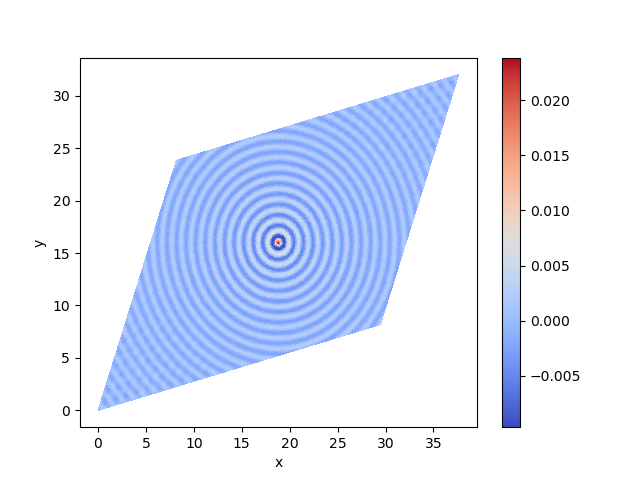

'\nplt.figure()\nplt.tripcolor(x,y,Uex.imag,cmap=cm.coolwarm) ################## plot en 2D\nplt.colorbar()\nplt.xlabel("x")\nplt.ylabel("y")\nplt.savefig("im_ex_075x070d")\n#plt.savefig("exd")\nplt.show()'

In [17]:
plt.figure()
plt.tripcolor(x,y,U.imag,cmap=cm.coolwarm) ################## plot en 2D
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("im_cond_11x10_ZEM")
#plt.savefig("Z2d")
plt.show()
"""
plt.figure()
plt.tripcolor(x,y,Uex.imag,cmap=cm.coolwarm) ################## plot en 2D
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("im_ex_075x070d")
#plt.savefig("exd")
plt.show()"""

<IPython.core.display.Javascript object>


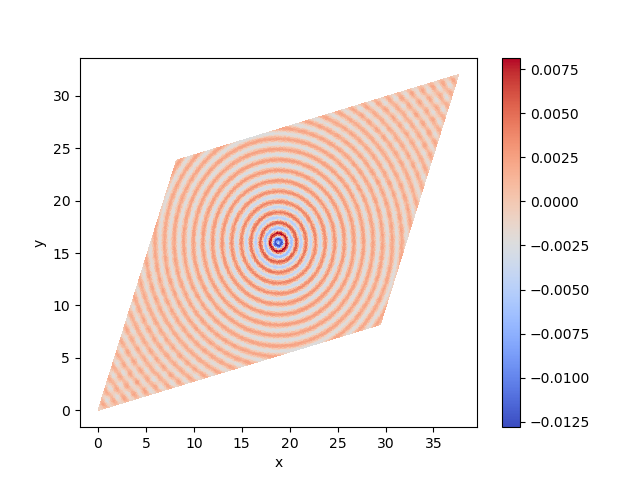

'\nplt.figure()\nplt.tripcolor(x,y,Uex.real,cmap=cm.coolwarm) ################## plot en 2D\nplt.colorbar()\nplt.xlabel("x")\nplt.ylabel("y")\nplt.savefig("re_ex_075x070d")\nplt.show()'

In [18]:
plt.figure()
plt.tripcolor(x,y,U.real,cmap=cm.coolwarm) ################## plot en 2D
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("re_cond_11x10_ZEM")
plt.show()
"""
plt.figure()
plt.tripcolor(x,y,Uex.real,cmap=cm.coolwarm) ################## plot en 2D
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("re_ex_075x070d")
plt.show()"""

<IPython.core.display.Javascript object>


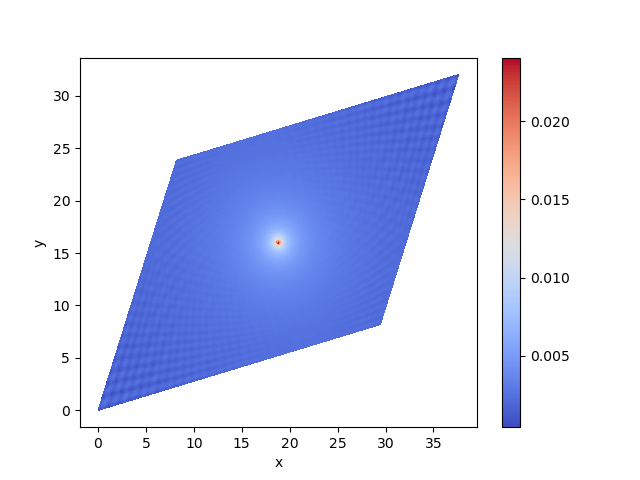

'\nplt.figure()\nplt.tripcolor(x,y,abs(Uex),cmap=cm.coolwarm) ################## plot en 2D\nplt.colorbar()\nplt.xlabel("x")\nplt.ylabel("y")\nplt.savefig("abs_ex_075x070d")\nplt.show()'

In [19]:
plt.figure()
plt.tripcolor(x,y,abs(U),cmap=cm.coolwarm) ################## plot en 2D
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("abs_cond_11x10_ZEM")
plt.show()
"""
plt.figure()
plt.tripcolor(x,y,abs(Uex),cmap=cm.coolwarm) ################## plot en 2D
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("abs_ex_075x070d")
plt.show()"""

<IPython.core.display.Javascript object>


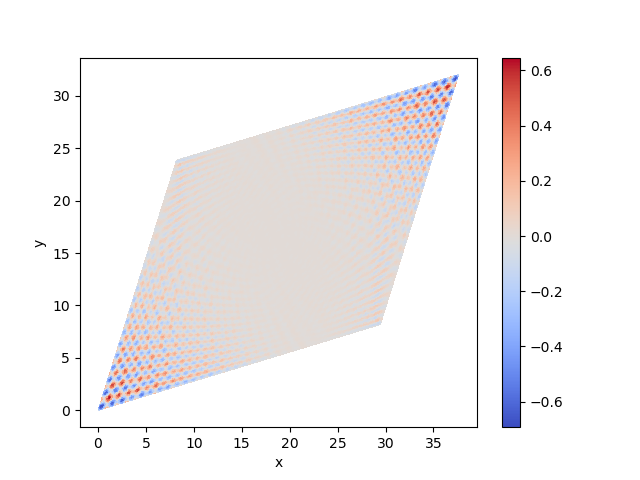

<IPython.core.display.Javascript object>


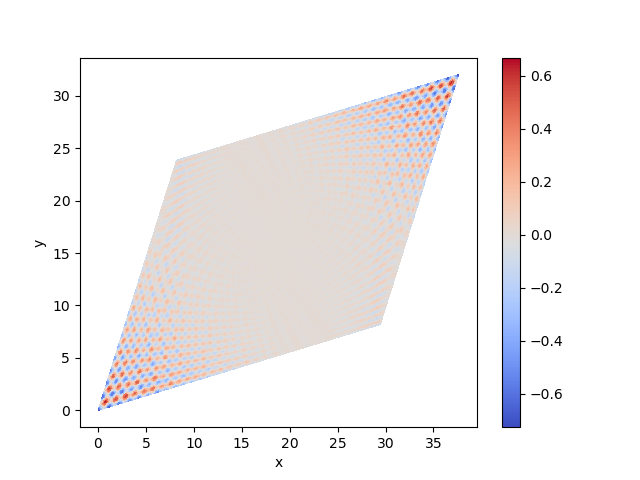

In [20]:
plt.figure()
plt.tripcolor(x,y,((U-Uex)/Uex).imag,cmap=cm.coolwarm) ################## plot en 2D
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("err_rel_im_11x10_ZEM")
plt.show()

plt.figure()
plt.tripcolor(x,y,((U-Uex)/Uex).real,cmap=cm.coolwarm) ################## plot en 2D
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("err_rel_re_11x10_Z2")
plt.show()

In [ ]:
plt.figure()
plt.tripcolor(x,y,abs((U-Uex)/Uex),cmap=cm.coolwarm) ################## plot en 2D
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("err_rel_abs_11x10_ZEM")
plt.show()

<IPython.core.display.Javascript object>

In [6]:

normL2=np.dot(np.conj(U-Uex),Masse*(U-Uex))/np.dot(np.conj(Uex),Masse*Uex)
print(normL2)
print(np.sqrt(abs(normL2)))

(nan+nanj)
nan


/tmp/ipykernel_4257/2968373509.py:1: RuntimeWarning: invalid value encountered in cdouble_scalars
  normL2=np.dot(np.conj(U-Uex),Masse*(U-Uex))/np.dot(np.conj(Uex),Masse*Uex)


In [13]:
t1=time.time()
file = open("matmasse.txt", 'r') ################### récupération de la sol exacte
line=file.readline()
a=line.split()
nonzero=int(a[0]) 
rowM=np.zeros(nonzero)
colM=np.zeros(nonzero)
dataM=np.zeros(nonzero)
for i in range(nonzero):
    line=file.readline()
    a=line.split()
    rowM[i]=int(a[0])
    colM[i]=int(a[1])
    dataM[i]=float(a[2])
file.close()
t2=time.time()
print('temps recup grosse mat masse',t2-t1)

temps recup grosse mat masse 118.11126041412354


In [14]:

Masse_ex=sp.csc_matrix((dataM,(rowM,colM)),shape=(nbGCex,nbGCex))

In [10]:
Ip=270
Jp=240
div=[2,3,5,6,10,15,30]
NN=len(div)
II=np.zeros(NN,dtype=int)
JJ=np.zeros(NN,dtype=int)
for i in range(NN):
    II[i]=int(270*np.ones(NN)[i]/div[i])
    JJ[i]=int(240*np.ones(NN)[i]/div[i])

longueur bas: 30.57147992190408
longueur gauche: 25.209888169892015
longueur trangle bas: 0.11322770341445955
longueur trangle gauche: 0.10504120070788339
N bas: 270
N gauche: 240
nb point maillage: 65311
nb ele: 129600
creation pts 62.5875027179718
temps tri 1944000 5.600682973861694
temps eff 1944000 9.738757848739624
rigidite 76.01727724075317
masse 74.97966980934143
masse bord 5.095016956329346
test intégrale F 0.15707963267948957 0.15707963267948966 -8.326672684688674e-17
inversion 488.2836787700653


<IPython.core.display.Javascript object>


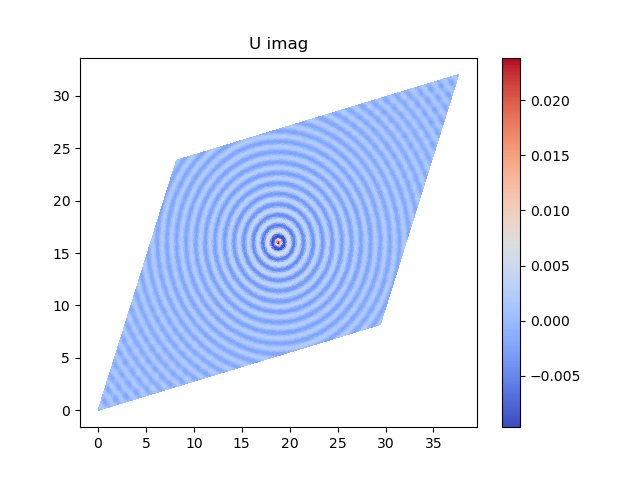

longueur bas: 30.57147992190408
longueur gauche: 25.209888169892015
longueur trangle bas: 0.2264554068289191
longueur trangle gauche: 0.21008240141576678
N bas: 135
N gauche: 120
nb point maillage: 16456
nb ele: 32400
creation pts 8.642326354980469
temps tri 486000 0.7834312915802002
temps eff 486000 1.2002763748168945
temps maillage 0 6640.555559396744


<IPython.core.display.Javascript object>


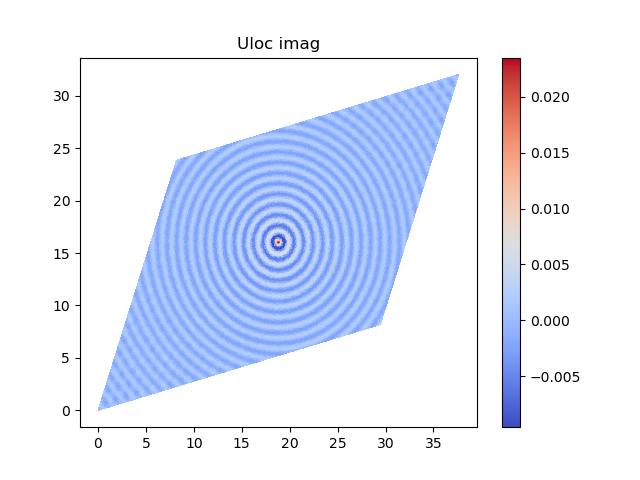

longueur bas: 30.57147992190408
longueur gauche: 25.209888169892015
longueur trangle bas: 0.33968311024337866
longueur trangle gauche: 0.3151236021236502
N bas: 90
N gauche: 80
nb point maillage: 7371
nb ele: 14400
creation pts 15.86547565460205
temps tri 216000 1.425330400466919
temps eff 216000 2.550445556640625
temps maillage 1 3952.422377347946


<IPython.core.display.Javascript object>


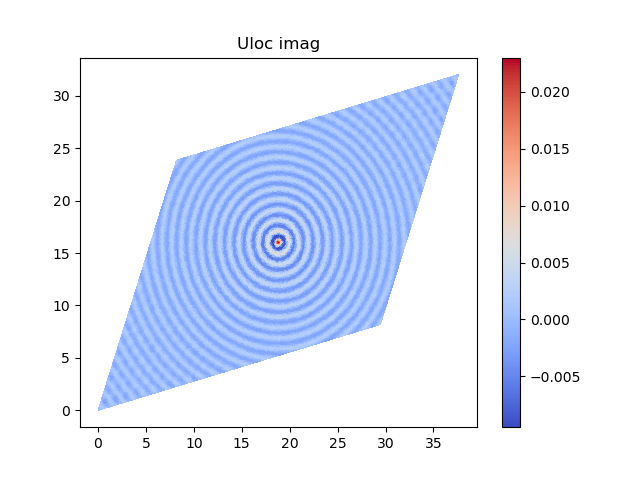

longueur bas: 30.57147992190408
longueur gauche: 25.209888169892015
longueur trangle bas: 0.5661385170722978
longueur trangle gauche: 0.5252060035394169
N bas: 54
N gauche: 48
nb point maillage: 2695
nb ele: 5184
creation pts 1.139117956161499
temps tri 77760 0.1639232635498047
temps eff 77760 0.21736955642700195
temps maillage 2 1517.9061694145203


<IPython.core.display.Javascript object>


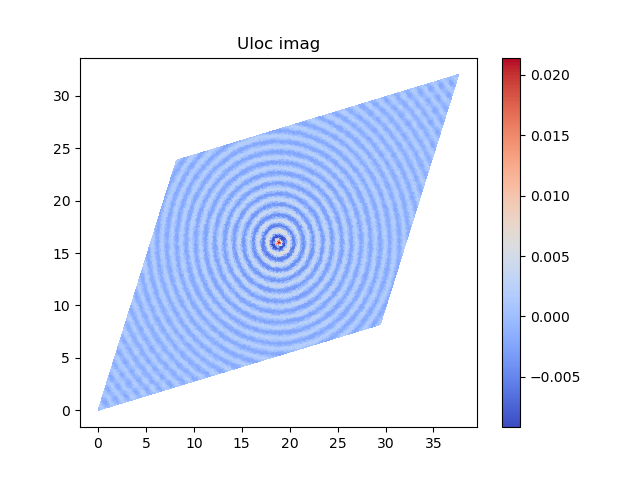

longueur bas: 30.57147992190408
longueur gauche: 25.209888169892015
longueur trangle bas: 0.6793662204867573
longueur trangle gauche: 0.6302472042473004
N bas: 45
N gauche: 40
nb point maillage: 1886
nb ele: 3600
creation pts 0.7666676044464111
temps tri 54000 0.08203792572021484
temps eff 54000 0.1599133014678955
temps maillage 3 1408.1472098827362


<IPython.core.display.Javascript object>


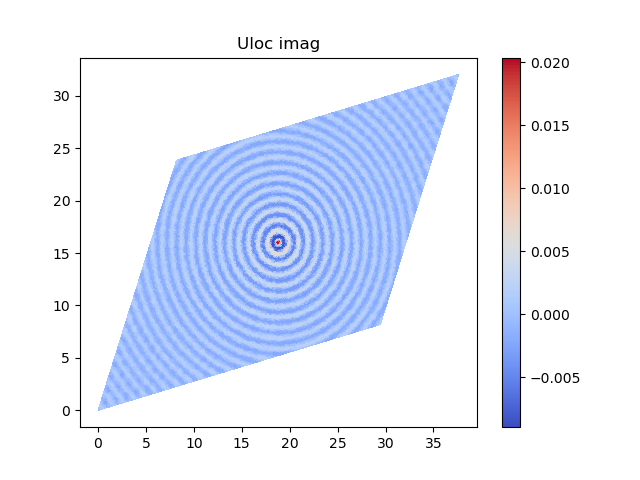

longueur bas: 30.57147992190408
longueur gauche: 25.209888169892015
longueur trangle bas: 1.1322770341445956
longueur trangle gauche: 1.0504120070788339
N bas: 27
N gauche: 24
nb point maillage: 700
nb ele: 1296
creation pts 0.30090880393981934
temps tri 19440 0.025036334991455078
temps eff 19440 0.046556949615478516
temps maillage 4 721.150057554245


<IPython.core.display.Javascript object>


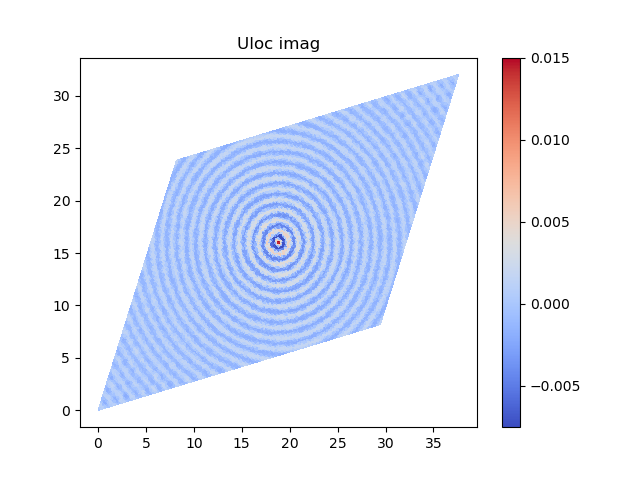

longueur bas: 30.57147992190408
longueur gauche: 25.209888169892015
longueur trangle bas: 1.6984155512168932
longueur trangle gauche: 1.575618010618251
N bas: 18
N gauche: 16
nb point maillage: 323
nb ele: 576
creation pts 0.11858487129211426
temps tri 8640 0.009767293930053711
temps eff 8640 0.023251056671142578
temps maillage 5 487.6587612628937


<IPython.core.display.Javascript object>


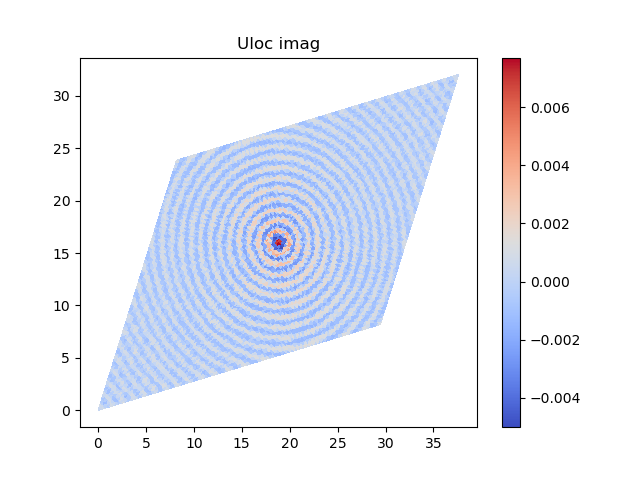

longueur bas: 30.57147992190408
longueur gauche: 25.209888169892015
longueur trangle bas: 3.3968311024337865
longueur trangle gauche: 3.151236021236502
N bas: 9
N gauche: 8
nb point maillage: 90
nb ele: 144
creation pts 0.35455799102783203
temps tri 2160 0.018744945526123047
temps eff 2160 0.039159297943115234
temps maillage 6 329.4688901901245


<IPython.core.display.Javascript object>


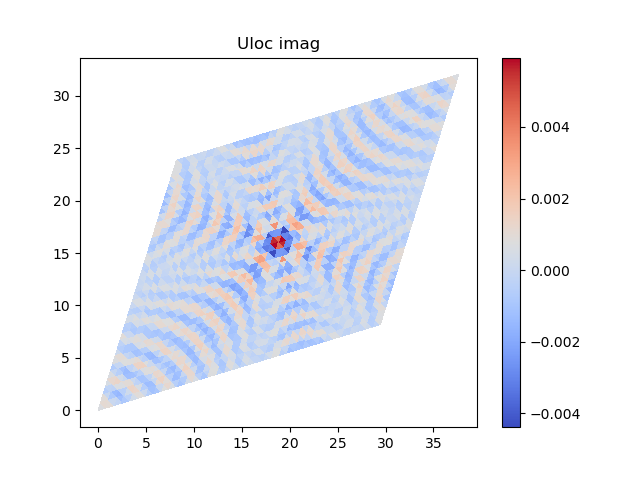

In [5]:

xp,yp,Up,Massep,hp=resolutionpetit(mg,kappa,Ip,Jp,II,JJ,donnee)


In [11]:
import os
from os import listdir
from os.path import isfile, join

In [12]:
import shutil
def lanceur(file_in_str,mg,loc):
    filin = open(file_in_str, "r")
    line=filin.readline()
    line=filin.readline()
    ii0=line.split()
    i0=int(ii0[0])
    print('-------------------------------------------------------------------------------------')
    print(i0)
    for i in range(i0):
        line=filin.readline()
        A=line.split()
        if A[0]=='I':
            line=filin.readline()
            hstring=line.split()
            I=int(hstring[0])
        if A[0]=='J':
            line=filin.readline()
            hstring=line.split()
            J=int(hstring[0])
        if A[0]=='kappa':
            line=filin.readline()
            hstring=line.split()
            kappa=float(hstring[0])        
    print('I=',I)
    print('J=',J)
    print('kappa=',kappa)
    donnee=1
    filin.close()
    x,y,U,Uex,Masse,R,Mbord,h=resolution(mg,kappa,I,J,donnee)
    file_str='out1_'+file_in_str
    file = open(file_str, "w") ######## écrire chaque sol
    file.write(f"{len(U)}\n")
    for i in range(len(U)):
        file.write(f"{U[i]}\n")
    file.close()
    normL2=np.sqrt(abs(np.dot(np.conj(U-Uex),Masse*(U-Uex))/np.dot(np.conj(Uex),Masse*Uex)))
    print('diviseur',np.dot(np.conj(Uex),Masse*Uex))
    print('normL2',normL2)
    semiH1=np.sqrt(abs(np.dot(np.conj(U-Uex),R*(U-Uex))/np.dot(np.conj(Uex),R*Uex)))
    print('semiH1',semiH1)
    normH1=np.sqrt(normL2**2+semiH1**2)
    normL2bord=np.sqrt(abs(np.dot(np.conj(U-Uex),Mbord*(U-Uex))/np.dot(np.conj(Uex),Mbord*Uex)))
    print('normL2bord',normL2bord)
    os.chdir('..')
    file = open('uloc_'+str(loc)+'.txt', 'r') ################### récupération de la sol exacte
    nbGC=len(x)
    Uloc=np.zeros(nbGC,dtype=complex) 
    for i in range(nbGC):
        line=file.readline()
        a=line.split()
        Uloc[i]=complex(a[0])
    file.close()
    os.chdir('INPUT')
    normL2cla=np.sqrt(abs(np.dot(np.conj(U-Uloc),Masse*(U-Uloc))/np.dot(np.conj(Uloc),Masse*Uloc)))
    print('normL2cla',normL2cla)
    semiH1cla=np.sqrt(abs(np.dot(np.conj(U-Uloc),R*(U-Uloc))/np.dot(np.conj(Uloc),R*Uloc)))
    print('semiH1cla',semiH1cla)
    normH1cla=np.sqrt(normL2cla**2+semiH1cla**2)
    normL2bordcla=np.sqrt(abs(np.dot(np.conj(U-Uloc),Mbord*(U-Uloc))/np.dot(np.conj(Uloc),Mbord*Uloc)))
    print('normL2bordcla',normL2bordcla)
    shutil.move(file_str,"DONE/"+file_str)
    shutil.move(file_in_str,"DONE/"+file_in_str)
    return(h,normL2,normL2cla,semiH1,semiH1cla,normH1,normH1cla,normL2bord,normL2bordcla)

In [13]:
######################## CRÉER LES FICHIERS ##################################

for i in range(NN):
    os.chdir("/home/alagarder003/Documents/PROJETM2/projetm2/INPUT")
    file_str='file_'+str(i)+'.txt'
    file = open(file_str, "w")
    file.write('nombre de lignes')
    file.write('\n')
    file.write('3')
    file.write('\n')
    file.write('kappa')
    file.write('\n')
    kappa=2*np.pi
    file.write(str(kappa))
    file.write('\n')
    file.write('I')
    file.write('\n')
    II[i]
    file.write(str(II[i]))
    file.write('\n')
    file.write('J')
    file.write('\n')
    JJ[i]
    file.write(str(JJ[i]))
    file.write('\n')
    file.close()


In [14]:
############################# LANCER LES FICHIERS #################################


os.chdir("/home/alagarder003/Documents/PROJETM2/projetm2")
fichiers = [f for f in listdir('INPUT') if isfile(join('INPUT', f))]
print(fichiers)
hh=np.zeros(NN)
errL2=np.zeros(NN)
errsemiH1=np.zeros(NN)
errH1=np.zeros(NN)
errL2bord=np.zeros(NN)
errclaL2=np.zeros(NN)
errclasemiH1=np.zeros(NN)
errclaH1=np.zeros(NN)
errclaL2bord=np.zeros(NN)
for i in range(NN):
    FILE ='file_'+str(i)+'.txt'
    print(FILE)
    os.chdir('INPUT')
    hh[i],errL2[i],errclaL2[i],errsemiH1[i],errclasemiH1[i],errH1[i],errclaH1[i],errL2bord[i],errclaL2bord[i]=lanceur(FILE,mg,i)
    os.chdir('..')

['maillage_reg.ele', 'file_5.txt', 'file_4.txt', 'file_1.txt', 'file_6.txt', 'file_3.txt', 'file_2.txt', 'maillage_reg.node', 'file_0.txt']
file_0.txt
-------------------------------------------------------------------------------------
3
I= 135
J= 120
kappa= 6.283185307179586
longueur bas: 30.57147992190408
longueur gauche: 25.209888169892015
longueur trangle bas: 0.2264554068289191
longueur trangle gauche: 0.21008240141576678
N bas: 135
N gauche: 120
nb point maillage: 16456
nb ele: 32400
creation pts 13.99685263633728
temps tri 486000 1.3812541961669922
temps eff 486000 2.686774969100952
nbGC 260221
rigidite 17.621947765350342
masse 35.48902940750122
masse bord 4.907906770706177
temps somme csc 0.30477333068847656
test intégrale F 0.1570796169210546 0.15707963267948966 -1.5758435056856257e-08
inversion 86.7502167224884
temps construction uex 260221 29.25513005256653
diviseur (0.00503994099079302+1.0164395367051604e-19j)
normL2 0.08481194229719398
semiH1 0.08513887939466587
normL2bor

In [15]:
print('h',hh)
print('L2',errL2)
print('semiH1',errsemiH1)
print('H1',errH1)
print('L2bord',errL2bord)
print('L2cla',errclaL2)
print('semiH1cla',errclasemiH1)
print('H1cla',errclaH1)
print('L2bordcla',errclaL2bord)

h [0.2182689  0.32740336 0.54567226 0.65480671 1.09134452 1.63701678
 3.27403356]
L2 [0.08481194 0.08568393 0.39917161 0.87036423 0.98610287 0.95785422
 3.08104649]
semiH1 [0.08513888 0.08737047 0.41200669 0.87996337 0.99493554 0.98909276
 3.48215447]
H1 [0.1201736  0.12237375 0.57366148 1.23768713 1.40081962 1.37687661
 4.64954269]
L2bord [0.19730032 0.19898473 0.58976048 1.04824995 1.04642246 1.02015555
 3.12004982]
L2cla [6.42273696e-04 1.23932456e-02 3.93485224e-01 8.74403001e-01
 9.85963311e-01 9.57661140e-01 3.03288145e+00]
semiH1cla [0.00375183 0.02127757 0.40812463 0.88361824 0.99488028 0.98905862
 3.44934583]
H1cla [3.80640524e-03 2.46237199e-02 5.66918279e-01 1.24312582e+00
 1.40068213e+00 1.37671777e+00 4.59307702e+00]
L2bordcla [8.19088426e-04 1.63865719e-02 5.53254575e-01 1.04144903e+00
 1.06543905e+00 1.02466231e+00 3.45529444e+00]


In [ ]:
vecerrexL2=np.ones(len(hh))*errexL2

plt.figure()

plt.plot(hh,errL2,marker='x',color='b',label='uh-uex')
plt.plot(hh,errclaL2,marker='x',color='r',label='uh-ucla')
plt.plot(hh,vecerrexL2,linestyle='--',label="uex-ucla")
plt.legend()
plt.loglog()
plt.axis('on')
plt.savefig("erreursL2_ZEM")
plt.plot(hh,hh**6,color="g",label="ordre 6")
plt.legend()
plt.savefig("erreursL2ordre_ZEM")
plt.show()



In [ ]:
vecerrexsemiH1=np.ones(len(hh))*errexsemiH1

plt.figure()
plt.plot(hh,errsemiH1,marker='x',color='b',label='uh-uex')
plt.plot(hh,errclasemiH1,marker='x',color='r',label='uh-ucla')
plt.plot(hh,vecerrexsemiH1,linestyle='--',label="uex-ucla")
plt.legend()
plt.loglog()
plt.savefig("erreurssemiH1_ZEM")
plt.plot(hh,hh**4,color="g",label="ordre 4")
plt.legend()
plt.savefig("erreurssemiH1ordre_ZEM")
plt.show()

In [ ]:
vecerrexH1=np.ones(len(hh))*errexH1

plt.figure()
plt.plot(hh,errH1,marker='x',color='b',label='uh-uex')
plt.plot(hh,errclaH1,marker='x',color='r',label='uh-ucla')
plt.plot(hh,vecerrexH1,linestyle='--',label="uex-ucla")
plt.legend()
plt.loglog()
plt.savefig("erreursH1_ZEM")
plt.plot(hh,hh**4,color="g",label="ordre 4")
plt.legend()
plt.savefig("erreursH1ordre_ZEM")
plt.show()

In [ ]:
vecerrexL2bord=np.ones(len(hh))*errexL2bord

plt.figure()
plt.plot(hh,errL2bord,marker='x',color='b',label='uh-uex')
plt.plot(hh,errclaL2bord,marker='x',color='r',label='uh-ucla')
plt.plot(hh,vecerrexL2bord,linestyle='--',label="uex-ucla")
plt.legend()
plt.loglog()
plt.savefig("erreursL2bord_ZEM")
plt.plot(hh,hh**6,color="g",label="ordre 6")
plt.legend()
plt.savefig("erreursL2bordordre_ZEM")
plt.show()

In [ ]:
plt.figure()
plt.plot(hh,errL2,marker='x',color='b',label='norme L2')
plt.plot(hh,errsemiH1,marker='x',color='r',label='semi norme H1')
plt.plot(hh,errH1,marker='x',color='g',label="norme H1")
plt.plot(hh,errL2bord,marker='x',color='y',label="norme L2 bord")
plt.legend()
plt.loglog()
plt.savefig("erreursUhUex_ZEM")
plt.show()

In [ ]:
plt.figure()
plt.plot(hh,errclaL2,marker='x',color='b',label='norme L2')
plt.plot(hh,errclasemiH1,marker='x',color='r',label='semi norme H1')
plt.plot(hh,errclaH1,marker='x',color='g',label="norme H1")
plt.plot(hh,errclaL2bord,marker='x',color='y',label='norme L2 bord')
plt.legend()
plt.loglog()
plt.savefig("erreursUhUcla_ZEM")
plt.show()